In [152]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory
from tqdm import tqdm
import os
import scipy.io
import scipy.misc
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
from PIL import Image
import numpy as np
import tensorflow as tf
from tensorflow.python.framework.ops import EagerTensor
import pprint
%matplotlib inline

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [153]:
DATA_DIR = "../input/test2/"

In [154]:
os.listdir(DATA_DIR)

['ocean.jpg', 'strudel.jpg', 'anya.jpg', 'monet.jpg']

# Main idea
In neural style transfer we combine the content of an image with the style of another image to generate a new image combining the content and style.

In [155]:
tf.random.set_seed(272) 
pp = pprint.PrettyPrinter(indent=4)
img_size = 400
vgg = tf.keras.applications.VGG19(include_top=False,
                                  input_shape=(img_size, img_size, 3),
                                  weights='imagenet')

vgg.trainable = False
pp.pprint(vgg)

# Task 1
In order to make the generated image match the content of the original image we need to extract the content of the image. We can do so with the content cost function.

## Background Info
The different layers in a NN detect different features of an image. Shallowers layers detect more high level features and deeper layers detect more fine-grained details. Therefore we choose some middle layer 'L' which will have a good understanding of both low-level and high-level features to represent `content` of the image. The activations of this layer `L` will be the numerical representation of `content` that we will feed to the generated image.

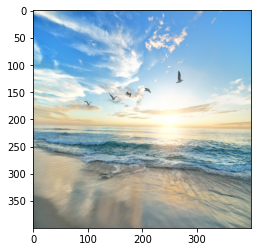

In [156]:
content_image = np.array(Image.open(DATA_DIR+'ocean.jpg').resize((400, 400)))
content_image = tf.constant(np.reshape(content_image, ((1,) + content_image.shape)))
imshow(content_image[0])
plt.show()

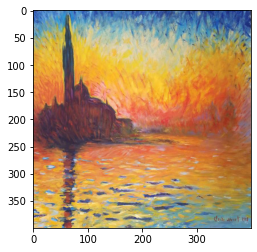

In [157]:
style_image = np.array(Image.open(DATA_DIR+'monet.jpg').resize((400, 400)))
style_image = tf.constant(np.reshape(style_image, ((1,) + style_image.shape)))
imshow(style_image[0])
plt.show()

(1, 400, 400, 3)


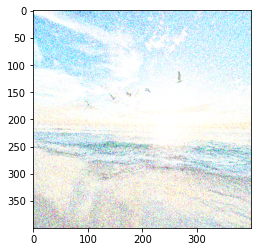

In [158]:
generated_image = tf.Variable(tf.image.convert_image_dtype(content_image, tf.float32))
noise = tf.random.uniform(tf.shape(generated_image), 0, 0.8)
generated_image = tf.add(generated_image, noise)
generated_image = tf.clip_by_value(generated_image, clip_value_min=0.0, clip_value_max=1.0)

print(generated_image.shape)
imshow(generated_image.numpy()[0])
plt.show()

In [159]:
def compute_content_cost(content_output, generated_output):
    """
    Computes the content cost
    
    Arguments:
    a_C -- tensor of dimension (1, n_H, n_W, n_C), hidden layer activations representing content of the image C 
    a_G -- tensor of dimension (1, n_H, n_W, n_C), hidden layer activations representing content of the image G
    
    Returns: 
    J_content -- scalar that you compute using equation 1 above.
    """
    
    a_C = content_output[-1]
    a_G = generated_output[-1]
    ### START CODE HERE
    
    # Retrieve dimensions from a_G (≈1 line)
    m, n_H, n_W, n_C = a_G.get_shape().as_list()
    
    # Reshape a_C and a_G (≈2 lines)
    a_C_unrolled = tf.reshape(a_C, shape=[m, n_H * n_W, n_C]) # Or tf.reshape(a_C, shape=[m, -1 , n_C])
    a_G_unrolled = tf.reshape(a_G, shape=[m, n_H * n_W, n_C]) # Or tf.reshape(a_G, shape=[m, -1 , n_C])
    
    # compute the cost with tensorflow (≈1 line)
    J_content =  tf.reduce_sum(tf.square(a_C_unrolled - a_G_unrolled))/(4.0 * n_H * n_W * n_C)
    
    ### END CODE HERE
    
    return J_content

In [160]:
tf.random.set_seed(1)
a_C = tf.random.normal([1, 4, 4, 3], mean=1, stddev=4)
a_G = tf.random.normal([1, 4, 4, 3], mean=1, stddev=4)
J_content = compute_content_cost([a_C], [a_G])
J_content_0 = compute_content_cost([a_C], [a_C])
assert type(J_content) == EagerTensor, "Use the tensorflow function"
assert np.isclose(J_content_0, 0.0), "Wrong value. compute_content_cost(A, A) must be 0"
assert np.isclose(J_content, 7.0568767), f"Wrong value. Expected {7.0568767},  current{J_content}"

print("J_content = " + str(J_content))

print("\033[92mAll tests passed")

J_content = tf.Tensor(7.056877, shape=(), dtype=float32)
All tests passed


# Calculating the style of an image using Gram matrix

In [161]:
def gram_matrix(A):
    return tf.matmul(A, tf.transpose(A))

In [162]:
tf.random.set_seed(1)
A = tf.random.normal([3, 2 * 1], mean=1, stddev=4)
GA = gram_matrix(A)

assert type(GA) == EagerTensor, "Use the tensorflow function"
assert GA.shape == (3, 3), "Wrong shape. Check the order of the matmul parameters"
assert np.allclose(GA[0,:], [63.1888, -26.721275, -7.7320204]), "Wrong values."

print("GA = \n" + str(GA))

print("\033[92mAll tests passed")

GA = 
tf.Tensor(
[[ 63.1888    -26.721275   -7.7320204]
 [-26.721275   12.76758    -2.5158243]
 [ -7.7320204  -2.5158243  23.752384 ]], shape=(3, 3), dtype=float32)
All tests passed


In [163]:
def compute_layer_style_cost(a_S, a_G):
    """
    Arguments:
    a_S -- tensor of dimension (1, n_H, n_W, n_C), hidden layer activations representing style of the image S 
    a_G -- tensor of dimension (1, n_H, n_W, n_C), hidden layer activations representing style of the image G
    
    Returns: 
    J_style_layer -- tensor representing a scalar value, style cost defined above by equation (2)
    """
#     a_S = a_S[-1]
#     a_G = a_G[-1]
    
    # Retrieve dimensions from a_G (≈1 line)
    m, n_H, n_W, n_C = a_G.get_shape().as_list()
    
    # Reshape a_C and a_G (≈2 lines)
    a_S = tf.transpose(tf.reshape(a_S, shape=[n_H * n_W, n_C])) 
    a_G = tf.transpose(tf.reshape(a_G, shape=[n_H * n_W, n_C])) 
    return  tf.reduce_sum(tf.square(gram_matrix(a_S) - gram_matrix(a_G)))/(4.0 *(( n_H * n_W * n_C)**2))
    

In [164]:
tf.random.set_seed(1)
a_S = tf.random.normal([1, 4, 4, 3], mean=1, stddev=4)
a_G = tf.random.normal([1, 4, 4, 3], mean=1, stddev=4)
J_style_layer_GG = compute_layer_style_cost(a_G, a_G)
J_style_layer_SG = compute_layer_style_cost(a_S, a_G)


assert type(J_style_layer_GG) == EagerTensor, "Use the tensorflow functions"
assert np.isclose(J_style_layer_GG, 0.0), "Wrong value. compute_layer_style_cost(A, A) must be 0"
assert J_style_layer_SG > 0, "Wrong value. compute_layer_style_cost(A, B) must be greater than 0 if A != B"
assert np.isclose(J_style_layer_SG, 14.017805), "Wrong value."

print("J_style_layer = " + str(J_style_layer_SG))

print("\033[92mAll tests passed")

J_style_layer = tf.Tensor(14.017804, shape=(), dtype=float32)
All tests passed


In [165]:
vgg.summary()

Model: "vgg19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         [(None, 400, 400, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 400, 400, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 400, 400, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 200, 200, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 200, 200, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 200, 200, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 100, 100, 128)     0     

In [166]:
for layer in vgg.layers:
    print(layer.name)

input_7
block1_conv1
block1_conv2
block1_pool
block2_conv1
block2_conv2
block2_pool
block3_conv1
block3_conv2
block3_conv3
block3_conv4
block3_pool
block4_conv1
block4_conv2
block4_conv3
block4_conv4
block4_pool
block5_conv1
block5_conv2
block5_conv3
block5_conv4
block5_pool


In [167]:
vgg.get_layer('block5_conv4').output

<KerasTensor: shape=(None, 25, 25, 512) dtype=float32 (created by layer 'block5_conv4')>

In [168]:
STYLE_LAYERS = [
    ('block1_conv1', 1.0),
    ('block2_conv1', 0.8),
    ('block3_conv1', 0.7),
    ('block4_conv1', 0.2),
    ('block5_conv1', 0.1)]

In [169]:
def compute_style_cost(style_image_output, generated_image_output, STYLE_LAYERS=STYLE_LAYERS):
    """
    Computes the overall style cost from several chosen layers
    
    Arguments:
    style_image_output -- our tensorflow model
    generated_image_output --
    STYLE_LAYERS -- A python list containing:
                        - the names of the layers we would like to extract style from
                        - a coefficient for each of them
    
    Returns: 
    J_style -- tensor representing a scalar value, style cost defined above by equation (2)
    """
    J_style = 0

    # Set a_S to be the hidden layer activation from the layer we have selected.
    # The first element of the array contains the input layer image, which must not to be used.
    a_S = style_image_output[1:]

    # Set a_G to be the output of the choosen hidden layers.
    # The First element of the list contains the input layer image which must not to be used.
    a_G = generated_image_output[1:]
    for i, weight in zip(range(len(a_S)), STYLE_LAYERS):  
        # Compute style_cost for the current layer
        J_style_layer = compute_layer_style_cost(a_S[i], a_G[i])

        # Add weight * J_style_layer of this layer to overall style cost
        J_style += weight[1] * J_style_layer

    return J_style

    

In [170]:
@tf.function()
def total_cost(J_content, J_style, alpha = 10, beta = 40):
    """
    Computes the total cost function
    
    Arguments:
    J_content -- content cost coded above
    J_style -- style cost coded above
    alpha -- hyperparameter weighting the importance of the content cost
    beta -- hyperparameter weighting the importance of the style cost
    
    Returns:
    J -- total cost as defined by the formula above.
    """
    return (alpha * J_content) + (beta * J_style)

In [171]:
J_content = 0.2    
J_style = 0.8
J = total_cost(J_content, J_style)

assert type(J) == EagerTensor, "Do not remove the @tf.function() modifier from the function"
assert J == 34, "Wrong value. Try inverting the order of alpha and beta in the J calculation"
assert np.isclose(total_cost(0.3, 0.5, 3, 8), 4.9), "Wrong value. Use the alpha and beta parameters"

np.random.seed(1)
print("J = " + str(total_cost(np.random.uniform(0, 1), np.random.uniform(0, 1))))

print("\033[92mAll tests passed")

J = tf.Tensor(32.9832, shape=(), dtype=float32)
All tests passed


# Define a function to load middle layers of VGG19
By using more than one layer, we can enhance the appearance of the generated image even more. 

In [172]:
def get_layer_outputs(vgg, layer_names):
    """ Creates a vgg model that returns a list of intermediate output values."""
    # layer_names has 'layer' elements in it.
    outputs = [vgg.get_layer(layer[0]).output for layer in layer_names]

    model = tf.keras.Model([vgg.input], outputs)
    return model

In [173]:
content_layer = [('block5_conv4', 1)]

vgg_model_outputs = get_layer_outputs(vgg, STYLE_LAYERS + content_layer)

In [174]:
content_target = vgg_model_outputs(content_image)  # Content encoder
style_targets = vgg_model_outputs(style_image)     # Style enconder

In [175]:
preprocessed_content =  tf.Variable(tf.image.convert_image_dtype(content_image, tf.float32))
a_C = vgg_model_outputs(preprocessed_content)

# Set a_G to be the hidden layer activation from same layer. Here, a_G references model['conv4_2'] 
# and isn't evaluated yet. Later in the code, we'll assign the image G as the model input.
a_G = vgg_model_outputs(generated_image)

# Compute the content cost
J_content = compute_content_cost(a_C, a_G)

print(J_content)

tf.Tensor(0.00677256, shape=(), dtype=float32)


In [176]:
preprocessed_style =  tf.Variable(tf.image.convert_image_dtype(style_image, tf.float32))
a_S = vgg_model_outputs(preprocessed_style)

# Compute the style cost
J_style = compute_style_cost(a_S, a_G)
print(J_style)

tf.Tensor(2793.7954, shape=(), dtype=float32)


In [177]:
def clip_0_1(image):
    """
    Truncate all the pixels in the tensor to be between 0 and 1
    
    Arguments:
    image -- Tensor
    J_style -- style cost coded above

    Returns:
    Tensor
    """
    return tf.clip_by_value(image, clip_value_min=0.0, clip_value_max=1.0)

def tensor_to_image(tensor):
    """
    Converts the given tensor into a PIL image
    
    Arguments:
    tensor -- Tensor
    
    Returns:
    Image: A PIL image
    """
    tensor = tensor * 255
    tensor = np.array(tensor, dtype=np.uint8)
    if np.ndim(tensor) > 3:
        assert tensor.shape[0] == 1
        tensor = tensor[0]
    return Image.fromarray(tensor)

In [178]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.03)


def train_step(generated_image, alpha = 10, beta = 40):
    with tf.GradientTape() as tape:
        # In this function you must use the precomputed encoded images a_S and a_C
        # Compute a_G as the vgg_model_outputs for the current generated image
        a_G = vgg_model_outputs(generated_image)
        J_style = compute_style_cost(a_S, a_G)
        J_content = compute_content_cost(a_C, a_G)
        J = total_cost(J_content, J_style, alpha, beta)
    grad = tape.gradient(J, generated_image)

    optimizer.apply_gradients([(grad, generated_image)])
    generated_image.assign(clip_0_1(generated_image))
    return J

In [179]:
generated_image = tf.Variable(tf.image.convert_image_dtype(content_image, tf.float32))

J1 = train_step(generated_image)
print(J1)
assert type(J1) == EagerTensor, f"Wrong type {type(J1)} != {EagerTensor}"
#assert np.isclose(J1, 10221.168), f"Unexpected cost for epoch 0: {J1} != {10221.168}"

J2 = train_step(generated_image)
print(J2)
#assert np.isclose(J2, 6081.23541, rtol=0.05), f"Unexpected cost for epoch 1: {J2} != {6081.2354}"

print("\033[92mAll tests passed")

tf.Tensor(42155.367, shape=(), dtype=float32)
tf.Tensor(22375.023, shape=(), dtype=float32)
All tests passed


In [ ]:
generated_image = tf.Variable(tf.image.convert_image_dtype(content_image, tf.float32))

epochs = 2501
for i in tqdm(range(epochs)):
    train_step(generated_image,alpha = 100, beta = 10**2)
    if i % 250 == 0:
        print(f"Epoch {i} ")
    if i % 500 == 0:
        image = tensor_to_image(generated_image)
        imshow(image)
        #image.save(f"output/image_{i}.jpg")
        plt.show() 

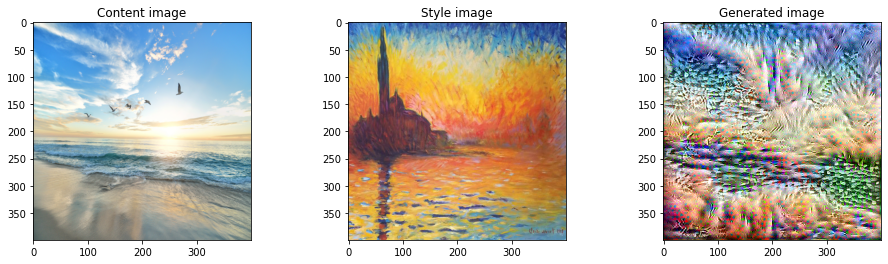

<Figure size 432x288 with 0 Axes>

In [181]:
# Show the 3 images in a row
fig = plt.figure(figsize=(16, 4))
ax = fig.add_subplot(1, 3, 1)
imshow(content_image[0])
ax.title.set_text('Content image')
ax = fig.add_subplot(1, 3, 2)
imshow(style_image[0])
ax.title.set_text('Style image')
ax = fig.add_subplot(1, 3, 3)
imshow(generated_image[0])
ax.title.set_text('Generated image')
plt.show()
plt.savefig("My_Result.jpg")